2/2 [==============================] - 0s 6ms/step
Epoch 0, Discriminator Loss: 1.976235717535019, Generator Loss: 0.19413787126541138
1/1 [==============================] - 0s 118ms/step


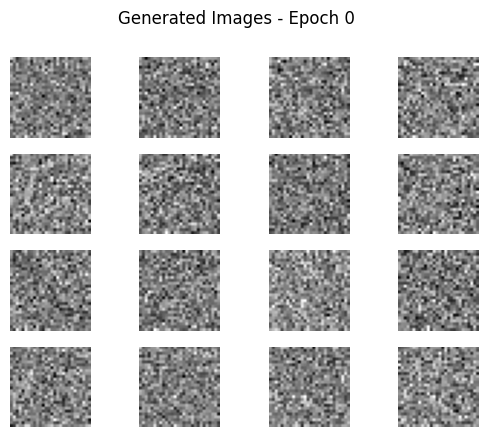

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


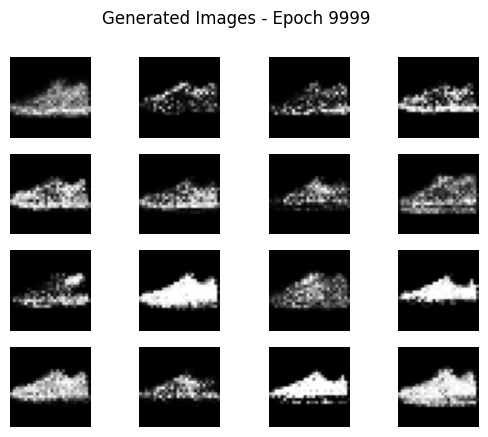

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the generator and discriminator models
def build_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(784, activation='sigmoid'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

def build_discriminator(img_shape):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN model that combines the generator and discriminator
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Function to display sample images
def display_generated_images(generator, latent_dim, epoch):
    gen_imgs = generator.predict(np.random.normal(0, 1, size=(16, latent_dim)))
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(4, 4)
    count = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    plt.suptitle(f"Generated Images - Epoch {epoch}")
    plt.show()

# Prepare the Fashion MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_train = np.expand_dims(x_train, axis=-1)

# Build and compile the discriminator
discriminator = build_discriminator((28, 28, 1))
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build and compile the generator
latent_dim = 100
generator = build_generator(latent_dim)
generator.compile(optimizer='adam', loss='binary_crossentropy')

# Build and compile the GAN model
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training the GAN
epochs = 10000
batch_size = 64

for epoch in range(epochs):
    # Generate noise for the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

    # Generate images using the generator
    generated_images = generator.predict(noise)

    # Select a random batch of real images from the dataset
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_images = x_train[idx]

    # Labels for real and fake images
    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    # Train the discriminator on real and fake images separately
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generate noise for the GAN
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

    # Labels for generated images (pretending they are real)
    labels_gan = np.ones((batch_size, 1))

    # Train the GAN (generator only)
    g_loss = gan.train_on_batch(noise, labels_gan)

    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")
        display_generated_images(generator, latent_dim, epoch)

display_generated_images(generator, latent_dim, epoch)